### Lab 3: Expectation Maximization and Variational Autoencoder

### Machine Learning 2 (2019)

* The lab exercises can be done in groups of two people, or individually.
* The deadline is Tuesday, October 15th at 17:00.
* Assignment should be submitted through Canvas! Make sure to include your and your teammates' names with the submission.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file should be "studentid1\_studentid2\_lab#", for example, the attached file should be "12345\_12346\_lab1.ipynb". Only use underscores ("\_") to connect ids, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask.
* Use __one cell__ for code and markdown answers only!
    * Put all code in the cell with the ```# YOUR CODE HERE``` comment and overwrite the ```raise NotImplementedError()``` line.
    * For theoretical questions, put your solution using LaTeX style formatting in the YOUR ANSWER HERE cell.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Large parts of you notebook will be graded automatically. Therefore it is important that your notebook can be run completely without errors and within a reasonable time limit. To test your notebook before submission, select Kernel -> Restart \& Run All.
$\newcommand{\bx}{\mathbf{x}} \newcommand{\bpi}{\mathbf{\pi}} \newcommand{\bmu}{\mathbf{\mu}} \newcommand{\bX}{\mathbf{X}} \newcommand{\bZ}{\mathbf{Z}} \newcommand{\bz}{\mathbf{z}}$

### Installing PyTorch

In this lab we will use PyTorch. PyTorch is an open source deep learning framework primarily developed by Facebook's artificial-intelligence research group. In order to install PyTorch in your conda environment go to https://pytorch.org and select your operating system, conda, Python 3.6, no cuda. Copy the text from the "Run this command:" box. Now open a terminal and activate your 'ml2labs' conda environment. Paste the text and run. After the installation is done you should restart Jupyter.

### MNIST data

In this Lab we will use several methods for unsupervised learning on the MNIST dataset of written digits. The dataset contains digital images of handwritten numbers $0$ through $9$. Each image has 28x28 pixels that each take 256 values in a range from white ($= 0$) to  black ($=1$). The labels belonging to the images are also included. 
Fortunately, PyTorch comes with a MNIST data loader. The first time you run the box below it will download the MNIST data set. That can take a couple of minutes.
The main data types in PyTorch are tensors. For Part 1, we will convert those tensors to numpy arrays. In Part 2, we will use the torch module to directly work with PyTorch tensors.

In [1]:
%pylab inline
import torch
from torchvision import datasets, transforms

train_dataset = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

train_labels = train_dataset.train_labels.numpy()
train_data = train_dataset.train_data.numpy()
# For EM we will use flattened data
train_data = train_data.reshape(train_data.shape[0], -1)


Populating the interactive namespace from numpy and matplotlib
Processing...
Done!


## Part 1: Expectation Maximization
We will use the Expectation Maximization (EM) algorithm for the recognition of handwritten digits in the MNIST dataset. The images are modelled as a Bernoulli mixture model (see Bishop $\S9.3.3$):
$$
p(\bx|\bmu, \bpi) = \sum_{k=1}^K  \pi_k \prod_{i=1}^D \mu_{ki}^{x_i}(1-\mu_{ki})^{(1-x_i)}
$$
where $x_i$ is the value of pixel $i$ in an image, $\mu_{ki}$ represents the probability that pixel $i$ in class $k$ is black, and $\{\pi_1, \ldots, \pi_K\}$ are the mixing coefficients of classes in the data. We want to use this data set to classify new images of handwritten numbers.

### 1.1 Binary data (5 points)
As we like to apply our Bernoulli mixture model, write a function `binarize` to convert the (flattened) MNIST data to binary images, where each pixel $x_i \in \{0,1\}$, by thresholding at an appropriate level.

In [2]:
def binarize(X):
    # YOUR CODE HERE
    #raise NotImplementedError()
    X = X/np.amax(X)
    
    X[X<0.5] = 0.
    X[X>=0.5] = 1.
    
    
    return X.astype(float)


In [3]:
# Test test test!
bin_train_data = binarize(train_data)
assert bin_train_data.dtype == np.float
assert bin_train_data.shape == train_data.shape


Sample a few images of digits $2$, $3$ and $4$; and show both the original and the binarized image together with their label.

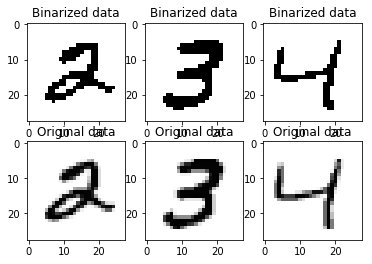

In [4]:
# YOUR CODE HERE
#raise NotImplementedError()

index2 = np.where(train_labels == 2)[0][0]
index3 = np.where(train_labels == 3)[0][0]
index4 = np.where(train_labels == 4)[0][0]

f = plt.figure()
f.add_subplot(2, 3, 1)
plt.imshow(bin_train_data[index2].reshape(28, 28), cmap='Greys')
plt.title('Binarized data')
f.add_subplot(2, 3, 2) 
plt.imshow(bin_train_data[index3].reshape(28, 28), cmap='Greys')
plt.title('Binarized data')
f.add_subplot(2, 3, 3) 
plt.imshow(bin_train_data[index4].reshape(28, 28), cmap='Greys')
plt.title('Binarized data')
f.add_subplot(2, 3, 4) 
plt.imshow(train_data[index2].reshape(28, 28), cmap='Greys')
plt.title('Original data')
f.add_subplot(2, 3, 5) 
plt.imshow(train_data[index3].reshape(28, 28), cmap='Greys')
plt.title('Original data')
f.add_subplot(2, 3, 6) 
plt.imshow(train_data[index4].reshape(28, 28), cmap='Greys')
plt.title('Original data');

### 1.2 Implementation (40 points)
You are going to write a function ```EM(X, K, max_iter)``` that implements the EM algorithm on the Bernoulli mixture model. 

The only parameters the function has are:
* ```X``` :: (NxD) array of input training images
* ```K``` :: size of the latent space
* ```max_iter``` :: maximum number of iterations, i.e. one E-step and one M-step

You are free to specify your return statement.

Make sure you use a sensible way of terminating the iteration process early to prevent unnecessarily running through all epochs. Vectorize computations using ```numpy``` as  much as possible.

You should implement the `E_step(X, mu, pi)` and `M_step(X, gamma)` separately in the functions defined below. These you can then use in your function `EM(X, K, max_iter)`.

In [126]:
def E_step(X, mu, pi):
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    gamma = []
    N = X.shape[0]
    for n in range(N):

        gamma_  = np.power( mu, X[n]) * np.power(1 - mu, 1 - X[n])
        gamma_  = np.prod(gamma_, axis = 1)
        gamma_  = np.multiply(gamma_, pi)
        gamma_ /= np.sum(gamma_)
        
        gamma.append(gamma_)
                     
    gamma = np.asarray(gamma)
    
    return gamma

In [127]:
# Let's test on 5 datapoints
n_test = 5
X_test = bin_train_data[:n_test]
D_test, K_test = X_test.shape[1], 10

np.random.seed(2018)
mu_test = np.random.uniform(low=.25, high=.75, size=(K_test,D_test))
pi_test = np.ones(K_test) / K_test

gamma_test = E_step(X_test, mu_test, pi_test)
assert gamma_test.shape == (n_test, K_test)


In [128]:
def M_step(X, gamma):
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    Nk = np.sum(gamma, 0)
    N = np.sum(Nk)
    mu = []
    K = gamma.shape[1]
    
    for k in range(K):
        mu.append(np.dot(gamma[:, k], X)/Nk[k])
        
    mu = np.asarray(mu)
    pi = Nk/N
    
    return mu, pi

In [129]:
# Oh, let's test again
mu_test, pi_test = M_step(X_test, gamma_test)

assert mu_test.shape == (K_test,D_test)
assert pi_test.shape == (K_test, )


In [132]:
def EM(X, K, max_iter, mu=None, pi=None):
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    eps = 1e-5
    if mu is None:
        mu = np.random.uniform(low=.25, high=.75, size=(K,X.shape[1]))
    if pi is None:
        pi = np.ones(K) / K
    
    for i in range(max_iter):
        mu_old, pi_old = np.copy(mu), np.copy(pi)
        gamma = E_step(X, mu, pi)
        mu, pi = M_step(X, gamma)
        
        if np.linalg.norm(mu_old - mu) < eps and np.linalg.norm(pi_old - pi) < eps:
            print('Iteration ', i, ' ||mu1-mu0|| = ', np.linalg.norm(mu_old - mu), ' ||pi1-pi0|| = ', np.linalg.norm(pi_old - pi))
            return gamma, mu, pi
        else:
            print('Iteration ', i, ' ||mu1-mu0|| = ', np.linalg.norm(mu_old - mu), ' ||pi1-pi0|| = ', np.linalg.norm(pi_old - pi))
        
    return gamma, mu, pi

### 1.3 Three digits experiment (10 points)
In analogue with Bishop $\S9.3.3$, sample a training set consisting of only __binary__ images of written digits $2$, $3$, and $4$. Run your EM algorithm and show the reconstructed digits.

In [133]:
# YOUR CODE HERE
#raise NotImplementedError()

K = 3
indices = np.where((train_labels >=2) & (train_labels <=4))
X = bin_train_data[indices]
gamma, mu, pi = EM(X, K, max_iter = 1000, mu=None, pi=None)

Iteration  0  ||mu1-mu0|| =  20.80451961676165  ||pi1-pi0|| =  0.28127282077143206
Iteration  1  ||mu1-mu0|| =  2.491817610221741  ||pi1-pi0|| =  0.07853000679136639
Iteration  2  ||mu1-mu0|| =  1.2328274054189576  ||pi1-pi0|| =  0.10727374063731926
Iteration  3  ||mu1-mu0|| =  1.0013101256850188  ||pi1-pi0|| =  0.06955867056457256
Iteration  4  ||mu1-mu0|| =  0.6067709295529693  ||pi1-pi0|| =  0.02761098136685654
Iteration  5  ||mu1-mu0|| =  0.32518644820772036  ||pi1-pi0|| =  0.011326813098334767
Iteration  6  ||mu1-mu0|| =  0.19052860758807377  ||pi1-pi0|| =  0.008723994906605768
Iteration  7  ||mu1-mu0|| =  0.1259509757821851  ||pi1-pi0|| =  0.007071360896095489
Iteration  8  ||mu1-mu0|| =  0.0833181149759813  ||pi1-pi0|| =  0.00515010687231672
Iteration  9  ||mu1-mu0|| =  0.053991904490827254  ||pi1-pi0|| =  0.0032434748054442166
Iteration  10  ||mu1-mu0|| =  0.03308341263788753  ||pi1-pi0|| =  0.002029541308418275
Iteration  11  ||mu1-mu0|| =  0.018822934359846312  ||pi1-pi0|| = 

Can you identify which element in the latent space corresponds to which digit? What are the identified mixing coefficients for digits $2$, $3$ and $4$, and how do these compare to the true ones?

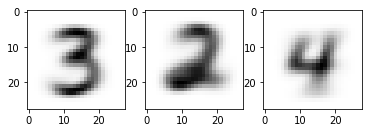

In [134]:
f = plt.figure()
f.add_subplot(1, 3, 1)
plt.imshow(mu[0].reshape(28, 28), cmap='Greys')
f.add_subplot(1, 3, 2) 
plt.imshow(mu[1].reshape(28, 28), cmap='Greys')
f.add_subplot(1, 3, 3) 
plt.imshow(mu[2].reshape(28, 28), cmap='Greys');

In [135]:
print('Mixing coeffcients: ', pi[1], ' ', pi[0], ' ', pi[2])

Mixing coeffcients:  0.3181069862583857   0.3328683328491127   0.3490246808925016


In [136]:
ind2 = len(np.where(train_labels ==2)[0])
ind2 /= len(indices[0])
ind3 = len(np.where(train_labels == 3)[0])
ind3 /= len(indices[0])
ind4 = len(np.where(train_labels == 4)[0])
ind4 /= len(indices[0])
print('Real mixing coefficients: ', ind2, ' ', ind3, ' ', ind4)

Real mixing coefficients:  0.33227371591099214   0.34192181138809885   0.32580447270090906


YOUR ANSWER HERE

Yes, we can identify which $\mu$ corresponds to which digit. First element $\mu_1$ correspond to 3, second  $\mu_2$ to 2, and third  $\mu_3$ to 4. Obtained mixing coeffcients does not differ from the real ones, which are computed by averaging the counts for each label. This indicates that we converged to the true solution.

### 1.4 Experiments (20 points)
Perform the follow-up experiments listed below using your implementation of the EM algorithm. For each of these, describe/comment on the obtained results and give an explanation. You may still use your dataset with only digits 2, 3 and 4 as otherwise computations can take very long.

#### 1.4.1 Size of the latent space (5 points)
Run EM with $K$ larger or smaller than the true number of classes. Describe your results.

Iteration  0  ||mu1-mu0|| =  11.820345507982484  ||pi1-pi0|| =  0.0
Iteration  1  ||mu1-mu0|| =  0.0  ||pi1-pi0|| =  0.0


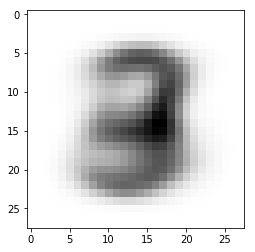

In [148]:
# YOUR CODE HERE
#raise NotImplementedError()

K = 1
indices = np.where((train_labels >=2) & (train_labels <=4))
X = bin_train_data[indices]
gamma, mu, pi = EM(X, K, max_iter = 1000, mu=None, pi=None)

f = plt.figure()
f.add_subplot(1, 1, 1)
plt.imshow(mu[0].reshape(28, 28), cmap='Greys')

Iteration  0  ||mu1-mu0|| =  16.76847380675752  ||pi1-pi0|| =  0.26267533565363077
Iteration  1  ||mu1-mu0|| =  1.0832550427235568  ||pi1-pi0|| =  0.0952445019569941
Iteration  2  ||mu1-mu0|| =  0.9452055739972997  ||pi1-pi0|| =  0.06184212165663634
Iteration  3  ||mu1-mu0|| =  0.9074047155498263  ||pi1-pi0|| =  0.014967503503025866
Iteration  4  ||mu1-mu0|| =  0.48554926895195594  ||pi1-pi0|| =  0.0225085943018757
Iteration  5  ||mu1-mu0|| =  0.3315424630674538  ||pi1-pi0|| =  0.023664319417709568
Iteration  6  ||mu1-mu0|| =  0.30444412183071673  ||pi1-pi0|| =  0.013776059427655116
Iteration  7  ||mu1-mu0|| =  0.2720656101991254  ||pi1-pi0|| =  6.945371225722458e-06
Iteration  8  ||mu1-mu0|| =  0.2605466601087206  ||pi1-pi0|| =  0.009757696297464136
Iteration  9  ||mu1-mu0|| =  0.2724816322471978  ||pi1-pi0|| =  0.020599742103791997
Iteration  10  ||mu1-mu0|| =  0.25842179802475523  ||pi1-pi0|| =  0.024850458674003803
Iteration  11  ||mu1-mu0|| =  0.2544946289013859  ||pi1-pi0|| =  0.

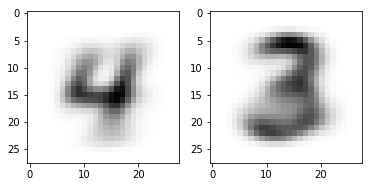

In [149]:
K = 2
indices = np.where((train_labels >=2) & (train_labels <=4))
X = bin_train_data[indices]
gamma, mu, pi = EM(X, K, max_iter = 1000, mu=None, pi=None)

f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(mu[0].reshape(28, 28), cmap='Greys')
f.add_subplot(1, 2, 2) 
plt.imshow(mu[1].reshape(28, 28), cmap='Greys')

Iteration  0  ||mu1-mu0|| =  24.043451100500786  ||pi1-pi0|| =  0.5792585176637735
Iteration  1  ||mu1-mu0|| =  4.0638896029498754  ||pi1-pi0|| =  0.2671676342597115
Iteration  2  ||mu1-mu0|| =  1.7855200048274964  ||pi1-pi0|| =  0.12158039327122126
Iteration  3  ||mu1-mu0|| =  0.7315562334088066  ||pi1-pi0|| =  0.04997383605049851
Iteration  4  ||mu1-mu0|| =  0.40376788330204033  ||pi1-pi0|| =  0.02026618656188793
Iteration  5  ||mu1-mu0|| =  0.4135182530492327  ||pi1-pi0|| =  0.014455777532160539
Iteration  6  ||mu1-mu0|| =  0.4098950758887079  ||pi1-pi0|| =  0.008675844236522262
Iteration  7  ||mu1-mu0|| =  0.3961994283446328  ||pi1-pi0|| =  0.0053159797119492445
Iteration  8  ||mu1-mu0|| =  0.3417707629166774  ||pi1-pi0|| =  0.0023382520426983287
Iteration  9  ||mu1-mu0|| =  0.2806759400050434  ||pi1-pi0|| =  0.002694496902149384
Iteration  10  ||mu1-mu0|| =  0.21253362819928182  ||pi1-pi0|| =  0.003497124191034797
Iteration  11  ||mu1-mu0|| =  0.16239549132683484  ||pi1-pi0|| =  0

Iteration  93  ||mu1-mu0|| =  0.0007580216640472499  ||pi1-pi0|| =  3.607270214811288e-05
Iteration  94  ||mu1-mu0|| =  0.0007444437187710334  ||pi1-pi0|| =  3.5453126056276265e-05
Iteration  95  ||mu1-mu0|| =  0.0007342047526844871  ||pi1-pi0|| =  3.4999587610297925e-05
Iteration  96  ||mu1-mu0|| =  0.0007270986800321573  ||pi1-pi0|| =  3.470035580976395e-05
Iteration  97  ||mu1-mu0|| =  0.0007228600748259515  ||pi1-pi0|| =  3.4539871339199506e-05
Iteration  98  ||mu1-mu0|| =  0.0007211050729035264  ||pi1-pi0|| =  3.449568363896209e-05
Iteration  99  ||mu1-mu0|| =  0.0007212654917227363  ||pi1-pi0|| =  3.4535075294631845e-05
Iteration  100  ||mu1-mu0|| =  0.0007225375206013871  ||pi1-pi0|| =  3.4612513625105914e-05
Iteration  101  ||mu1-mu0|| =  0.0007238862459271093  ||pi1-pi0|| =  3.466995413935552e-05
Iteration  102  ||mu1-mu0|| =  0.0007254481737031984  ||pi1-pi0|| =  3.458227955321796e-05
Iteration  103  ||mu1-mu0|| =  0.002182266928199769  ||pi1-pi0|| =  3.1550217002409566e-05
I

Iteration  184  ||mu1-mu0|| =  0.0009245261726769949  ||pi1-pi0|| =  3.790191732189557e-05
Iteration  185  ||mu1-mu0|| =  0.0007795619968730998  ||pi1-pi0|| =  3.183997247893768e-05
Iteration  186  ||mu1-mu0|| =  0.0006573851412321989  ||pi1-pi0|| =  2.6688851816070966e-05
Iteration  187  ||mu1-mu0|| =  0.0005543314931045892  ||pi1-pi0|| =  2.2341313272650183e-05
Iteration  188  ||mu1-mu0|| =  0.0004673819642380139  ||pi1-pi0|| =  1.86889189409764e-05
Iteration  189  ||mu1-mu0|| =  0.0003940171853097565  ||pi1-pi0|| =  1.562958360488733e-05
Iteration  190  ||mu1-mu0|| =  0.0003321206042202389  ||pi1-pi0|| =  1.3071517474129996e-05
Iteration  191  ||mu1-mu0|| =  0.00027990787929866787  ||pi1-pi0|| =  1.0934568820289459e-05
Iteration  192  ||mu1-mu0|| =  0.00023587237651745709  ||pi1-pi0|| =  9.15002836762244e-06
Iteration  193  ||mu1-mu0|| =  0.00019883140729617352  ||pi1-pi0|| =  7.650151558011436e-06
Iteration  194  ||mu1-mu0|| =  0.0004135292270048131  ||pi1-pi0|| =  6.92779529743190

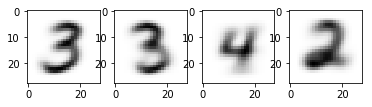

In [150]:
K = 4
indices = np.where((train_labels >=2) & (train_labels <=4))
X = bin_train_data[indices]
gamma, mu, pi = EM(X, K, max_iter = 1000, mu=None, pi=None)

f = plt.figure()
f.add_subplot(1, 4, 1)
plt.imshow(mu[0].reshape(28, 28), cmap='Greys')
f.add_subplot(1, 4, 2) 
plt.imshow(mu[1].reshape(28, 28), cmap='Greys')
f.add_subplot(1, 4, 3)
plt.imshow(mu[2].reshape(28, 28), cmap='Greys')
f.add_subplot(1, 4, 4) 
plt.imshow(mu[3].reshape(28, 28), cmap='Greys')

Iteration  0  ||mu1-mu0|| =  26.71339525146601  ||pi1-pi0|| =  0.4458988157028818
Iteration  1  ||mu1-mu0|| =  4.257368523347123  ||pi1-pi0|| =  0.3563544797713248
Iteration  2  ||mu1-mu0|| =  1.1501043564012152  ||pi1-pi0|| =  0.03889941618321261
Iteration  3  ||mu1-mu0|| =  0.5845283295441123  ||pi1-pi0|| =  0.010139361189836741
Iteration  4  ||mu1-mu0|| =  0.4955902502480529  ||pi1-pi0|| =  0.0061764099060585805
Iteration  5  ||mu1-mu0|| =  0.47720815838637937  ||pi1-pi0|| =  0.008820872120627637
Iteration  6  ||mu1-mu0|| =  0.4207899565190225  ||pi1-pi0|| =  0.009210566459073513
Iteration  7  ||mu1-mu0|| =  0.35322596746658397  ||pi1-pi0|| =  0.007867493729069834
Iteration  8  ||mu1-mu0|| =  0.3037445372305573  ||pi1-pi0|| =  0.008110882464522387
Iteration  9  ||mu1-mu0|| =  0.2445098890743878  ||pi1-pi0|| =  0.006858062198314332
Iteration  10  ||mu1-mu0|| =  0.19020832882413033  ||pi1-pi0|| =  0.005512157494996936
Iteration  11  ||mu1-mu0|| =  0.13265834880638516  ||pi1-pi0|| =  0

Iteration  92  ||mu1-mu0|| =  2.043098919467193e-05  ||pi1-pi0|| =  1.0368775514889931e-06
Iteration  93  ||mu1-mu0|| =  1.7351121794441225e-05  ||pi1-pi0|| =  9.110067147326023e-07
Iteration  94  ||mu1-mu0|| =  1.495952674645964e-05  ||pi1-pi0|| =  8.040221248620432e-07
Iteration  95  ||mu1-mu0|| =  1.3034804103899747e-05  ||pi1-pi0|| =  7.116485021777732e-07
Iteration  96  ||mu1-mu0|| =  1.1439668339853395e-05  ||pi1-pi0|| =  6.310314363420754e-07
Iteration  97  ||mu1-mu0|| =  1.0087880843713641e-05  ||pi1-pi0|| =  5.601851241778398e-07
Iteration  98  ||mu1-mu0|| =  8.923840751565446e-06  ||pi1-pi0|| =  4.976522855620526e-07


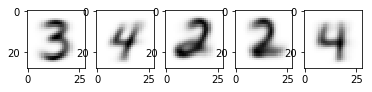

In [151]:
K = 5
indices = np.where((train_labels >=2) & (train_labels <=4))
X = bin_train_data[indices]
gamma, mu, pi = EM(X, K, max_iter = 1000, mu=None, pi=None)

f = plt.figure()
f.add_subplot(1, 5, 1)
plt.imshow(mu[0].reshape(28, 28), cmap='Greys')
f.add_subplot(1, 5, 2) 
plt.imshow(mu[1].reshape(28, 28), cmap='Greys')
f.add_subplot(1, 5, 3)
plt.imshow(mu[2].reshape(28, 28), cmap='Greys')
f.add_subplot(1, 5, 4) 
plt.imshow(mu[3].reshape(28, 28), cmap='Greys')
f.add_subplot(1, 5, 5) 
plt.imshow(mu[4].reshape(28, 28), cmap='Greys')

YOUR ANSWER HERE

When model is run with smaller K, we observe that cluster means does not represent particluar digits, but tries to aggregate features from multiple digits into one cluster. Interestingly, when run with K=2 model discriminates between 4 and 2,3. This again could be explained by similar patterns in digits 2 and 3. 

When I run model with K>3, obtained cluster means repeatedly represents some of the digits, which proves that K>3 is redundant to model this data. 


#### 1.4.2 Identify misclassifications (10 points)
How can you use the data labels to assign a label to each of the clusters/latent variables? Use this to identify images that are 'misclassified' and try to understand why they are. Report your findings.

In [152]:
# YOUR CODE HERE
#raise NotImplementedError()


In [137]:
dic = {0:3, 1:2, 2:4}

In [138]:
def replace_with_dict2_generic(ar, dic, assume_all_present=True):
    '''
    taken from
    https://stackoverflow.com/questions/47171356/replace-values-in-numpy-array-based-on-dictionary-and-avoid-overlap-between-new
    '''
    # Extract out keys and values
    k = np.array(list(dic.keys()))
    v = np.array(list(dic.values()))

    # Get argsort indices
    sidx = k.argsort()

    ks = k[sidx]
    vs = v[sidx]
    idx = np.searchsorted(ks,ar)

    if assume_all_present==0:
        idx[idx==len(vs)] = 0
        mask = ks[idx] == ar
        return np.where(mask, vs[idx], ar)
    else:
        return vs[idx]

In [139]:
true_labels = train_labels[(train_labels>=2) & (train_labels <=4)]
pred_labels_ = np.argmax(gamma, 1)
pred_labels = replace_with_dict2_generic(pred_labels_, dic, assume_all_present=True)
misclassified_indices = (true_labels!=pred_labels)
misclassified_X = X[misclassified_indices]
misclassified_pred = pred_labels[misclassified_indices]
misclassified_true = true_labels[misclassified_indices]
print(misclassified_X.shape[0], 'out of ', X.shape[0],' images are misclassified.')
unique, counts = numpy.unique(misclassified_true, return_counts=True)
misclassified_dict = dict(zip(unique, counts))
for i in misclassified_dict:
    print(i, ' is missclassified ', misclassified_dict[i], ' times. ')

1718 out of  17931  images are misclassified.
2  is missclassified  885  times. 
3  is missclassified  756  times. 
4  is missclassified  77  times. 


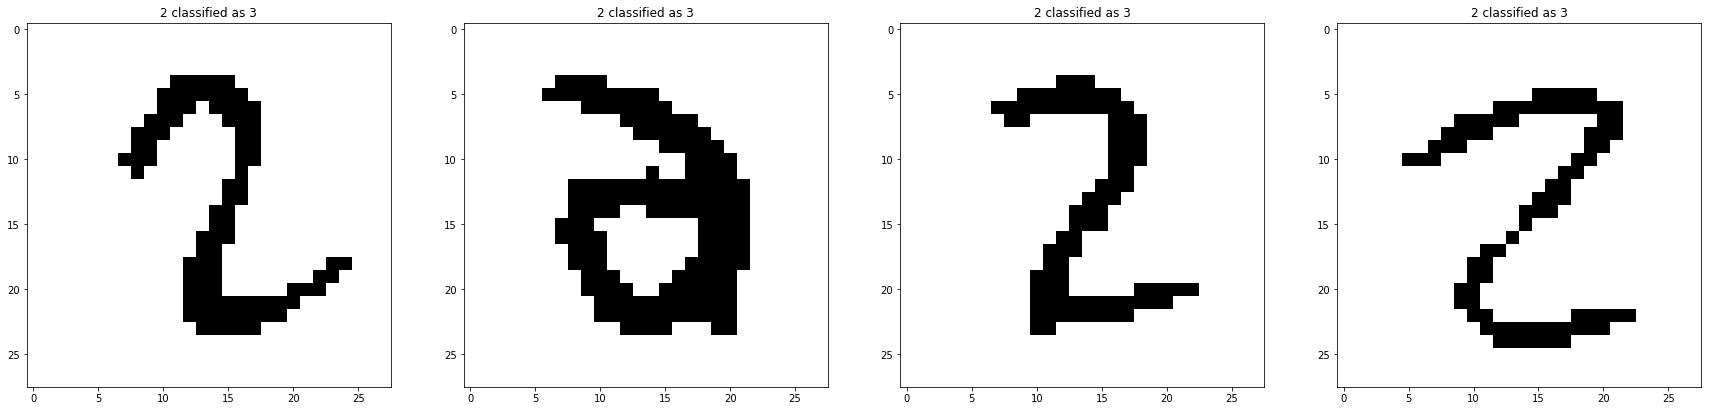

In [140]:
N_samples = 4

misclassified_2_indices = np.where(misclassified_true == 2)[0]
sample_ind2 = random.randint(0,misclassified_2_indices.shape[0], N_samples)
sample_ind = misclassified_2_indices[sample_ind2]

f = plt.figure(figsize=(30,20))
plt.subplots_adjust(bottom=.05, top=.95, hspace=.1)
for i in range(N_samples):
    f.add_subplot(i//10 + 1, N_samples, i+1)
    plt.imshow(misclassified_X[sample_ind[i]].reshape(28, 28), cmap='Greys')
    text = str(misclassified_true[sample_ind[i]])+ ' classified as '+ str(misclassified_pred[sample_ind[i]])
    plt.title(text)

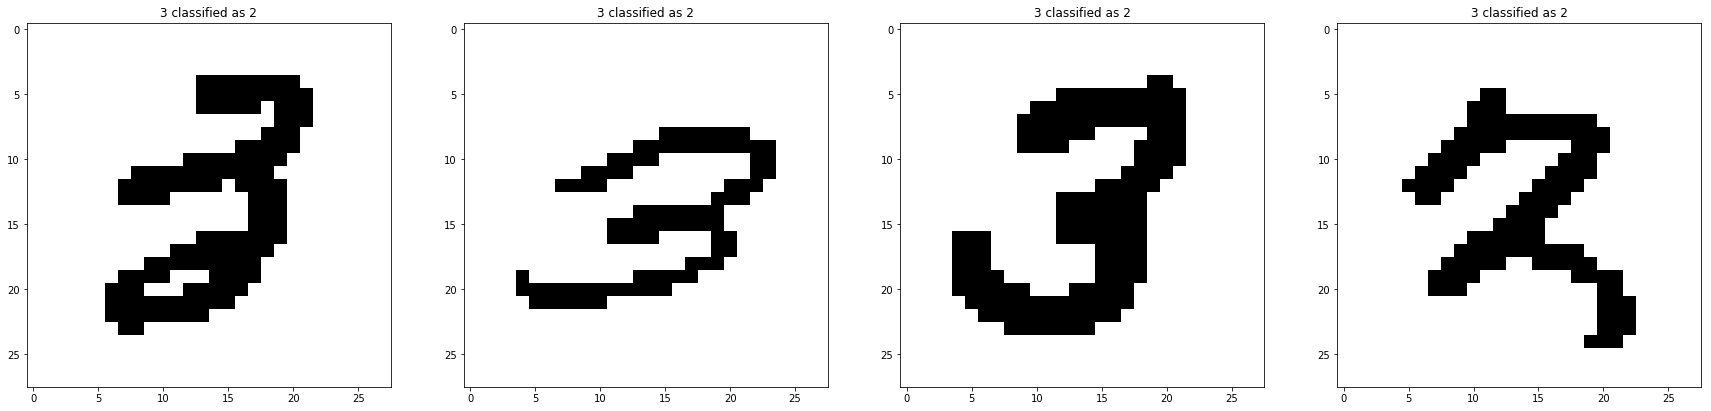

In [141]:
N_samples = 4


misclassified_3_indices = np.where(misclassified_true == 3)[0]
sample_ind3 = random.randint(0,misclassified_3_indices.shape[0], N_samples)
sample_ind = misclassified_3_indices[sample_ind3]

f = plt.figure(figsize=(30,20))
plt.subplots_adjust(bottom=.05, top=.95, hspace=.1)
for i in range(N_samples):
    f.add_subplot(i//10 + 1, N_samples, i+1)
    plt.imshow(misclassified_X[sample_ind[i]].reshape(28, 28), cmap='Greys')
    text = str(misclassified_true[sample_ind[i]])+ ' classified as '+ str(misclassified_pred[sample_ind[i]])
    plt.title(text)

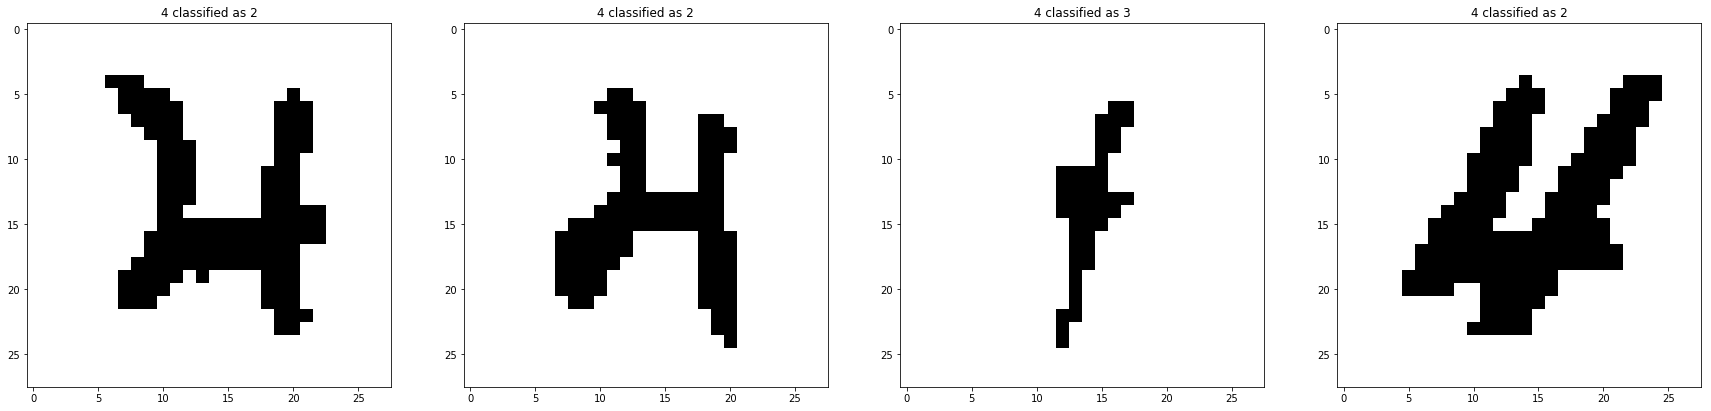

In [142]:
N_samples = 4

misclassified_4_indices = np.where(misclassified_true == 4)[0]
sample_ind4 = random.randint(0,misclassified_4_indices.shape[0], N_samples)
sample_ind = misclassified_4_indices[sample_ind4]

f = plt.figure(figsize=(30,20))
plt.subplots_adjust(bottom=.05, top=.95, hspace=.1)
for i in range(N_samples):
    f.add_subplot(i//10 + 1, N_samples, i+1)
    plt.imshow(misclassified_X[sample_ind[i]].reshape(28, 28), cmap='Greys')
    text = str(misclassified_true[sample_ind[i]])+ ' classified as '+ str(misclassified_pred[sample_ind[i]])
    plt.title(text)

YOUR ANSWER HERE

To assign label to the image, we look at the gamma coeffients, a vector with responsibilities that an image corresponds to a particular cluster, so we assign cluster with highest reponsibility:
$$label = argmax_{i}(\gamma_2, \gamma_3, \gamma_4)$$ We also can assign labels by identifiyng the nearest cluster mean by using $l2-norm$. 


2 and 3 missclafied most often, I hypothesize that it happens because these digits have similar curves and indeed resemble each other, while 4 has quite distinct lines and probably easier to discern among present digits. Also if we look at arbitrarily chosen missclassified images, we see that some of them are written not clearly and sometimes it is impossible to guess which digit is written even for human.

#### 1.4.3 Initialize with true values (5 points)
Initialize the three classes with the true values of the parameters and see what happens. Report your results.

In [143]:
mu_real2 = np.mean(bin_train_data[np.where(train_labels ==2)], 0)
mu_real3 = np.mean(bin_train_data[np.where(train_labels ==3)], 0)
mu_real4 = np.mean(bin_train_data[np.where(train_labels ==4)], 0)
mu_real = np.array([pi_real2, pi_real3, pi_real4])

ind2 = len(np.where(train_labels ==2)[0])
ind2 /= len(indices[0])
ind3 = len(np.where(train_labels == 3)[0])
ind3 /= len(indices[0])
ind4 = len(np.where(train_labels == 4)[0])
ind4 /= len(indices[0])
pi_real = np.array([ind2, ind3, ind4])


In [144]:
# YOUR CODE HERE
#raise NotImplementedError()

K = 3
indices = np.where((train_labels >=2) & (train_labels <=4))
X = bin_train_data[indices]

gamma_init, mu_init, pi_init = EM(X, K, max_iter = 1000, mu=mu_real, pi=pi_real)

Iteration  0  ||mu1-mu0|| =  0.45849699109256514  ||pi1-pi0|| =  0.017516958992891428
Iteration  1  ||mu1-mu0|| =  0.1633501029568555  ||pi1-pi0|| =  0.005212376538528878
Iteration  2  ||mu1-mu0|| =  0.08819779438032997  ||pi1-pi0|| =  0.0017159886405431863
Iteration  3  ||mu1-mu0|| =  0.04571291143637877  ||pi1-pi0|| =  0.0008666190597328344
Iteration  4  ||mu1-mu0|| =  0.023703764235154263  ||pi1-pi0|| =  0.00047176749346522327
Iteration  5  ||mu1-mu0|| =  0.012361390967112253  ||pi1-pi0|| =  0.0002355330531225217
Iteration  6  ||mu1-mu0|| =  0.006571960939865155  ||pi1-pi0|| =  0.00012986109017584956
Iteration  7  ||mu1-mu0|| =  0.0035380104021702804  ||pi1-pi0|| =  7.674059300841668e-05
Iteration  8  ||mu1-mu0|| =  0.0018647406549309616  ||pi1-pi0|| =  4.2725988661193625e-05
Iteration  9  ||mu1-mu0|| =  0.0009817982278108833  ||pi1-pi0|| =  2.434377297409398e-05
Iteration  10  ||mu1-mu0|| =  0.0005206659573903278  ||pi1-pi0|| =  1.4321626551103142e-05
Iteration  11  ||mu1-mu0|| =  

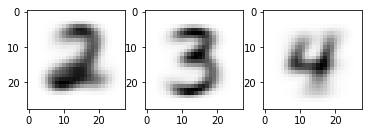

In [145]:
f = plt.figure()
f.add_subplot(1, 3, 1)
plt.imshow(mu_init[0].reshape(28, 28), cmap='Greys')
f.add_subplot(1, 3, 2) 
plt.imshow(mu_init[1].reshape(28, 28), cmap='Greys')
f.add_subplot(1, 3, 3) 
plt.imshow(mu_init[2].reshape(28, 28), cmap='Greys');

In [146]:
dic = {0:2, 1:3, 2:4}

In [147]:
true_labels = train_labels[(train_labels>=2) & (train_labels <=4)]
pred_labels_ = np.argmax(gamma_init, 1)
pred_labels = replace_with_dict2_generic(pred_labels_, dic, assume_all_present=True)
misclassified_indices = (true_labels!=pred_labels)
misclassified_X = X[misclassified_indices]
misclassified_pred = pred_labels[misclassified_indices]
misclassified_true = true_labels[misclassified_indices]
print(misclassified_X.shape[0], 'out of ', X.shape[0],' images are misclassified.')
unique, counts = numpy.unique(misclassified_true, return_counts=True)
misclassified_dict = dict(zip(unique, counts))
for i in misclassified_dict:
    print(i, ' is missclassified ', misclassified_dict[i], ' times. ')

1586 out of  17931  images are misclassified.
2  is missclassified  773  times. 
3  is missclassified  731  times. 
4  is missclassified  82  times. 


YOUR ANSWER HERE


When initialised with real values, we see that the norm of change in parameter values is already low on the initial stages of training and the algorithm converges faster. We also see that more images are classified correctly. 

So we can conclude that in more complex tasks, e.g. when we have more clusters, good initilisation has positive effect on the convergence.

## Part 2: Variational Auto-Encoder

A Variational Auto-Encoder (VAE) is a probabilistic model $p(\bx, \bz)$ over observed variables $\bx$ and latent variables and/or parameters $\bz$. Here we distinguish the decoder part, $p(\bx | \bz) p(\bz)$ and an encoder part $p(\bz | \bx)$ that are both specified with a neural network. A lower bound on the log marginal likelihood $\log p(\bx)$ can be obtained by approximately inferring the latent variables z from the observed data x using an encoder distribution $q(\bz| \bx)$ that is also specified as a neural network. This lower bound is then optimized to fit the model to the data. 

The model was introduced by Diederik Kingma (during his PhD at the UVA) and Max Welling in 2013, https://arxiv.org/abs/1312.6114. 

Since it is such an important model there are plenty of well written tutorials that should help you with the assignment. E.g: https://jaan.io/what-is-variational-autoencoder-vae-tutorial/.

In the following, we will make heavily use of the torch module, https://pytorch.org/docs/stable/index.html. Most of the time replacing `np.` with `torch.` will do the trick, e.g. `np.sum` becomes `torch.sum` and `np.log` becomes `torch.log`. In addition, we will use `torch.FloatTensor()` as an equivalent to `np.array()`. In order to train our VAE efficiently we will make use of batching. The number of data points in a batch will become the first dimension of our data tensor, e.g. A batch of 128 MNIST images has the dimensions [128, 1, 28, 28]. To check check the dimensions of a tensor you can call `.size()`.

### 2.1 Loss function
The objective function (variational lower bound), that we will use to train the VAE, consists of two terms: a log Bernoulli loss (reconstruction loss) and a Kullback–Leibler divergence. We implement the two terms separately and combine them in the end.
As seen in Part 1: Expectation Maximization, we can use a multivariate Bernoulli distribution to model the likelihood $p(\bx | \bz)$ of black and white images. Formally, the variational lower bound is maximized but in PyTorch we are always minimizing therefore we need to calculate the negative log Bernoulli loss and Kullback–Leibler divergence.

### 2.1.1 Negative Log Bernoulli loss (5 points)
The negative log Bernoulli loss is defined as,

\begin{align}
loss = - (\sum_i^D \bx_i \log \hat{\bx_i} + (1 − \bx_i) \log(1 − \hat{\bx_i})).
\end{align}

Write a function `log_bernoulli_loss` that takes a D dimensional vector `x`, its reconstruction `x_hat` and returns the negative log Bernoulli loss. Make sure that your function works for batches of arbitrary size.

In [2]:
def log_bernoulli_loss(x_hat, x):
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    loss = torch.mul(x, torch.log(x_hat)) + torch.mul(1 - x, torch.log(1 - x_hat))
    loss = -torch.sum(loss)

    return loss


In [3]:
### Test test test
x_test = torch.FloatTensor([[0.1, 0.2, 0.3, 0.4], [0.5, 0.6, 0.7, 0.8], [0.9, 0.9, 0.9, 0.9]])
x_hat_test = torch.FloatTensor([[0.11, 0.22, 0.33, 0.44], [0.55, 0.66, 0.77, 0.88], [0.99, 0.99, 0.99, 0.99]])

assert log_bernoulli_loss(x_hat_test, x_test) > 0.0
assert log_bernoulli_loss(x_hat_test, x_test) < 10.0


### 2.1.2 Negative Kullback–Leibler divergence (10 Points)
The variational lower bound (the objective to be maximized) contains a KL term $D_{KL}(q(\bz)||p(\bz))$ that can often be calculated analytically. In the VAE we assume $q = N(\bz, \mu, \sigma^2I)$ and $p = N(\bz, 0, I)$. Solve analytically!

YOUR ANSWER HERE


$$D_{KL}(q(\bz)||p(\bz)) =  - \int q(\bz) log \frac{p(\bz)}{q(\bz)} d\bz = \int \frac{1}{(2 \pi)^{\frac{K}{2}} (\det\sigma^2 I)^{\frac{1}{2}}} e^{-\frac{1}{2}(\bz - \mu)^T(\sigma^2 I)^{-1}(\bz - \mu)} \ln \frac{(\det \sigma^2 I )^{\frac{1}{2}}  e^{-\frac{1}{2}(\bz)^T(\bz)}}{K^{\frac{1}{2}}  e^{-\frac{1}{2}(\bz - \mu)^T(\sigma^2 I)^{-1}(\bz - \mu)}} = -\frac{1}{2}\ln \frac{(\sigma^2)^K}{1} + \frac{1}{2}\int q(\bz) \bz^T \bz d\bz - \frac{1}{2}\int q(\bz) (\bz - \mu)^T (\sigma^2 I )^{-1}(\bz - \mu) d\bz =  -\frac{K}{2}\ln \sigma^2 + \frac{1}{2}(\mu^T\mu + K \sigma^2) - \frac{K}{2} = - \frac{1}{2}(K \ln \sigma^2 + K - \mu^T\mu - K \sigma^2) $$



Write a function `KL_loss` that takes two J dimensional vectors `mu` and `logvar` and returns the negative Kullback–Leibler divergence. Where `logvar` is $\log(\sigma^2)$. Make sure that your function works for batches of arbitrary size.

In [4]:
def KL_loss(mu, logvar):
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    loss = -1/2*torch.sum(1+logvar - mu.pow(2) - torch.exp(logvar))
    return loss


In [5]:
### Test test test
mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

assert KL_loss(mu_test, logvar_test) > 0.0
assert KL_loss(mu_test, logvar_test) < 10.0


### 2.1.3 Putting the losses together (5 points)
Write a function `loss_function` that takes a D dimensional vector `x`, its reconstruction `x_hat`, two J dimensional vectors `mu` and `logvar` and returns the final loss. Make sure that your function works for batches of arbitrary size.

In [6]:
def loss_function(x_hat, x, mu, logvar):
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    loss =  (log_bernoulli_loss(x_hat, x) + KL_loss(mu, logvar))#/x.size(0)
    return loss


In [7]:
x_test = torch.FloatTensor([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]])
x_hat_test = torch.FloatTensor([[0.11, 0.22, 0.33], [0.44, 0.55, 0.66], [0.77, 0.88, 0.99]])
mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

assert loss_function(x_hat_test, x_test, mu_test, logvar_test) > 0.0
assert loss_function(x_hat_test, x_test, mu_test, logvar_test) < 10.0


### 2.2 The model
Below you see a data structure for the VAE. The modell itself consists of two main parts the encoder (images $\bx$ to latent variables $\bz$) and the decoder (latent variables $\bz$ to images $\bx$). The encoder is using 3 fully-connected layers, whereas the decoder is using fully-connected layers. Right now the data structure is quite empty, step by step will update its functionality. For test purposes we will initialize a VAE for you. After the data structure is completed you will do the hyperparameter search.


In [8]:
from torch import nn
from torch.nn import functional as F 

class VAE(nn.Module):
    def __init__(self, fc1_dims, fc21_dims, fc22_dims, fc3_dims, fc4_dims):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(*fc1_dims)
        self.fc21 = nn.Linear(*fc21_dims)
        self.fc22 = nn.Linear(*fc22_dims)
        self.fc3 = nn.Linear(*fc3_dims)
        self.fc4 = nn.Linear(*fc4_dims)

    def encode(self, x):
        # To be implemented
        raise Exception('Method not implemented')

    def reparameterize(self, mu, logvar):
        # To be implemented
        raise Exception('Method not implemented')

    def decode(self, z):
        # To be implemented
        raise Exception('Method not implemented')

    def forward(self, x):
        # To be implemented
        raise Exception('Method not implemented')

VAE_test = VAE(fc1_dims=(784, 4), fc21_dims=(4, 2), fc22_dims=(4, 2), fc3_dims=(2, 4), fc4_dims=(4, 784))


### 2.3 Encoding (10 points)
Write a function `encode` that gets a vector `x` with 784 elements (flattened MNIST image) and returns `mu` and `logvar`. Your function should use three fully-connected layers (`self.fc1()`, `self.fc21()`, `self.fc22()`). First, you should use `self.fc1()` to embed `x`. Second, you should use `self.fc21()` and `self.fc22()` on the embedding of `x` to compute `mu` and `logvar` respectively. PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.  

In [9]:
def encode(self, x):
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    x_ = F.relu(self.fc1(x))
    logvar = self.fc21(x_)
    mu = self.fc22(x_)
    return mu, logvar


In [10]:
### Test, test, test
VAE.encode = encode

x_test = torch.ones((5,784))
mu_test, logvar_test = VAE_test.encode(x_test)

assert np.allclose(mu_test.size(), [5, 2])
assert np.allclose(logvar_test.size(), [5, 2])


### 2.4 Reparameterization (10 points)
One of the major question that the VAE is answering, is 'how to take derivatives with respect to the parameters of a stochastic variable?', i.e. if we are given $\bz$ that is drawn from a distribution $q(\bz|\bx)$, and we want to take derivatives. This step is necessary to be able to use gradient-based optimization algorithms like SGD.
For some distributions, it is possible to reparameterize samples in a clever way, such that the stochasticity is independent of the parameters. We want our samples to deterministically depend on the parameters of the distribution. For example, in a normally-distributed variable with mean $\mu$ and standard deviation $\sigma$, we can sample from it like this:

\begin{align}
\bz = \mu + \sigma \odot \epsilon,
\end{align}

where $\odot$ is the element-wise multiplication and $\epsilon$ is sampled from $N(0, I)$.


Write a function `reparameterize` that takes two J dimensional vectors `mu` and `logvar`. It should return $\bz = \mu + \sigma \odot \epsilon$.


In [11]:
def reparameterize(self, mu, logvar):
            
        # YOUR CODE HERE
        #raise NotImplementedError()
        N, K = mu.size()
        eps = torch.autograd.Variable(torch.randn(N, K))
        z = mu + torch.exp(logvar / 2) * eps
        return z


In [12]:
### Test, test, test
VAE.reparameterize = reparameterize
VAE_test.train()

mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

z_test = VAE_test.reparameterize(mu_test, logvar_test)

assert np.allclose(z_test.size(), [3, 2])
assert z_test[0][0] < 5.0
assert z_test[0][0] > -5.0


### 2.5 Decoding (10 points)
Write a function `decode` that gets a vector `z` with J elements and returns a vector `x_hat` with 784 elements (flattened MNIST image). Your function should use two fully-connected layers (`self.fc3()`, `self.fc4()`). PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.

In [13]:
def decode(self, z):
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    z_ = F.relu(self.fc3(z))
    x_hat = torch.sigmoid(self.fc4(z_))
    return x_hat


In [14]:
# test test test
VAE.decode = decode

z_test = torch.ones((5,2))
x_hat_test = VAE_test.decode(z_test)

assert np.allclose(x_hat_test.size(), [5, 784])
assert (x_hat_test <= 1).all()
assert (x_hat_test >= 0).all()


### 2.6 Forward pass (10)
To complete the data structure you have to define a forward pass through the VAE. A single forward pass consists of the encoding of an MNIST image $\bx$ into latent space $\bz$, the reparameterization of $\bz$ and the decoding of $\bz$ into an image $\bx$.

Write a function `forward` that gets a a vector `x` with 784 elements (flattened MNIST image) and returns a vector `x_hat` with 784 elements (flattened MNIST image), `mu` and `logvar`.

In [15]:
def forward(self, x):
    x = x.view(-1, 784)
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    x_hat = self.decode(z)
    return x_hat, mu, logvar


In [16]:
# test test test 
VAE.forward = forward

x_test = torch.ones((5,784))
x_hat_test, mu_test, logvar_test = VAE_test.forward(x_test)

assert np.allclose(x_hat_test.size(), [5, 784])
assert np.allclose(mu_test.size(), [5, 2])
assert np.allclose(logvar_test.size(), [5, 2])


### 2.7 Training (15)
We will now train the VAE using an optimizer called Adam, https://arxiv.org/abs/1412.6980. The code to train a model in PyTorch is given below.

In [22]:
from torch.autograd import Variable

def train(epoch, train_loader, model, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        print('data ', data.size(), ' recon_batch ', recon_batch.size(), ' mu ', mu.size())
        loss = loss_function(recon_batch, data.view(-1, 784), mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [77]:
from torch.autograd import Variable

def train(epoch, train_loader, model, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data.view(-1, 784), mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


Let's train. You have to choose the hyperparameters. Make sure your loss is going down in a reasonable amount of epochs (around 10).

In [23]:
# Hyperparameters
# fc1_dims = (?,?)
# fc21_dims =
# fc22_dims =
# fc3_dims =
# fc4_dims =
# lr =
# batch_size =
# epochs =

# YOUR CODE HERE
#raise NotImplementedError()


fc1_dims = (784, 500)
fc21_dims = (500, 20)
fc22_dims = (500, 20)
fc3_dims = (20, 500)
fc4_dims = (500, 784)
lr = 1e-3
batch_size = 64
epochs = 15


In [24]:
# This cell contains a hidden test, please don't delete it, thx

Run the box below to train the model using the hyperparameters you entered above.

In [25]:
from torchvision import datasets, transforms
from torch import nn, optim

# Load data
train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, shuffle=True, **{})

# Init model
VAE_MNIST = VAE(fc1_dims=fc1_dims, fc21_dims=fc21_dims, fc22_dims=fc22_dims, fc3_dims=fc3_dims, fc4_dims=fc4_dims)

# Init optimizer
optimizer = optim.Adam(VAE_MNIST.parameters(), lr=lr)

# Train
for epoch in range(1, epochs + 1):
    train(epoch, train_loader, VAE_MNIST, optimizer)


Processing...
Done!
data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
Train Epoch: 1 [0/60000 (0%)]	Loss: 547.277832
data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])

data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
data  torch.Size([64, 1, 28, 28])  recon

data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
data  torch.Size([64, 1, 28, 28])  recon_batch  torch.Size([64, 784])  mu  torch.Size([64, 20])
data  torch.Size([64, 1, 28, 28])  recon

KeyboardInterrupt: 

Run the box below to check if the model you trained above is able to correctly reconstruct images.

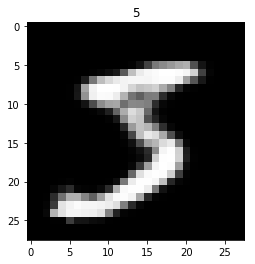

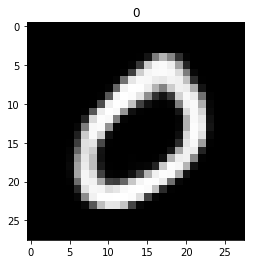

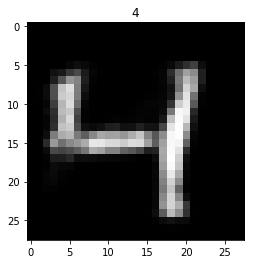

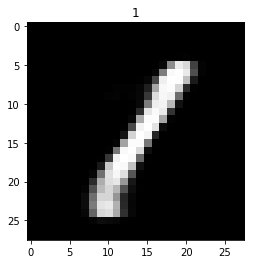

In [84]:
### Let's check if the reconstructions make sense
# Set model to test mode
VAE_MNIST.eval()
    
# Reconstructed
train_data_plot = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader_plot = torch.utils.data.DataLoader(train_data_plot,
                                           batch_size=1, shuffle=False, **{})

for batch_idx, (data, _) in enumerate(train_loader_plot):
    x_hat, mu, logvar = VAE_MNIST(data)
    plt.imshow(x_hat.view(1,28,28).squeeze().data.numpy(), cmap='gray')
    plt.title('%i' % train_data.train_labels[batch_idx])
    plt.show()
    if batch_idx == 3:
        break


### 2.8 Visualize latent space (20 points)
Now, implement the auto-encoder now with a 2-dimensional latent space, and train again over the MNIST data. Make a visualization of the learned manifold by using a linearly spaced coordinate grid as input for the latent space, as seen in  https://arxiv.org/abs/1312.6114 Figure 4.

In [87]:
# YOUR CODE HERE
#raise NotImplementedError()


fc1_dims = (784, 500)
fc21_dims = (500, 2)
fc22_dims = (500, 2)
fc3_dims = (2, 500)
fc4_dims = (500, 784)
lr = 1e-3
batch_size = 64
epochs = 7

VAE_MNIST = VAE(fc1_dims=fc1_dims, fc21_dims=fc21_dims, fc22_dims=fc22_dims, fc3_dims=fc3_dims, fc4_dims=fc4_dims)
optimizer = optim.Adam(VAE_MNIST.parameters(), lr=lr)

# Train
for epoch in range(1, epochs + 1):
    train(epoch, train_loader, VAE_MNIST, optimizer)


Train Epoch: 1 [0/60000 (0%)]	Loss: 549.224670
Train Epoch: 1 [6400/60000 (11%)]	Loss: 196.131287
Train Epoch: 1 [12800/60000 (21%)]	Loss: 180.121567
Train Epoch: 1 [19200/60000 (32%)]	Loss: 180.922638
Train Epoch: 1 [25600/60000 (43%)]	Loss: 180.975937
Train Epoch: 1 [32000/60000 (53%)]	Loss: 161.276093
Train Epoch: 1 [38400/60000 (64%)]	Loss: 162.726761
Train Epoch: 1 [44800/60000 (75%)]	Loss: 169.991776
Train Epoch: 1 [51200/60000 (85%)]	Loss: 162.510208
Train Epoch: 1 [57600/60000 (96%)]	Loss: 159.134705
====> Epoch: 1 Average loss: 179.0396
Train Epoch: 2 [0/60000 (0%)]	Loss: 158.276810
Train Epoch: 2 [6400/60000 (11%)]	Loss: 162.698273
Train Epoch: 2 [12800/60000 (21%)]	Loss: 162.712784
Train Epoch: 2 [19200/60000 (32%)]	Loss: 157.391968
Train Epoch: 2 [25600/60000 (43%)]	Loss: 160.440109
Train Epoch: 2 [32000/60000 (53%)]	Loss: 161.979919
Train Epoch: 2 [38400/60000 (64%)]	Loss: 164.567642
Train Epoch: 2 [44800/60000 (75%)]	Loss: 168.579239
Train Epoch: 2 [51200/60000 (85%)]	Los

In [90]:
def plot_manifold():
    
    VAE_MNIST.eval()

    import numpy as np
    from scipy.stats import norm
    from torchvision.utils import make_grid

    p = np.linspace(0.01, 0.99, 20)
    z = norm.ppf(p)
    z_code = []
    for z1 in z:
        for z2 in z:
            z_code.append([z1, z2])
    z_code = torch.FloatTensor(z_code)
    
    x = VAE_MNIST.decode(z_code).reshape(400, 1, 28, 28)
    
    im_means  = x

    plt.figure()
    grid_img = make_grid(im_means, nrow=20).detach()
    plt.title('Learned MNIST manifold')
    plt.imshow(grid_img.permute(1, 2, 0), )

    plt.tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)

    title = 'vae_dim2.png'
    plt.savefig(title, dpi=100)

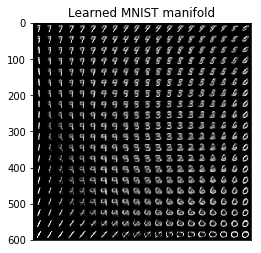

In [91]:
plot_manifold()

### 2.8 Amortized inference (10 points)
What is amortized inference? Where in the code of Part 2 is it used? What is the benefit of using it?


YOUR ANSWER HERE


Amortized inference refers to the sharing parameters of the approximate posterior accross datapoints. In comparison with mean-field approach, when parameters are not shared, amortized inference provides clear inference procedure for new datapoints, and makes learning easier, as we need to optimize for less number of parameters. We use amortized inference, when model decoder as a neural network, which implies that parameters of the posterior are shared.